In [ ]:
# cell for importing packages for the first time
# import Pkg; Pkg.add("StaticArrays")
# import Pkg; Pkg.add("Revise")


# import Pkg; Pkg.add("@time")
Pkg.add("FastGaussQuadrature")

In [ ]:
ENV["PYTHON"]=""
import Pkg;
Pkg.add("PyCall")

In [ ]:
Pkg.add("PyPlot")

In [1]:
using Plots

using StaticArrays
import LinearAlgebra
import FastGaussQuadrature

push!(LOAD_PATH, pwd())

module PhysConst
    export CL,Gr,QE,MSOL,MSUN,ARAD,SGMB,RGAS,
            PC,RSUN,RSUN,YR,MSOLYR,GAM53,KPE,PARSEC,KPE,KPD,M_MW
    CL = 2.997925E10;
    Gr = 6.67384E-8; 
    QE=4.80325E-10;
    MSOL = 1.989E33;
    MSUN = 1.989E33;

    ARAD = 7.56464E-15; 
    SGMB = ARAD*CL/4
    
    KBLZ = 1.3807E-16 

    HPL = 6.6261E-27 
    HPLB= 1.0546E-27

    RGAS = 8.31E7; 
    PC = 3.085678E18;

    MP = 1.672661E-24;
    ME = 9.1094E-28

    QE=4.8032E-10

    M_U = 1.660531E-24
    RSOL = 6.95E10
    RSUN = 6.95E10
    YR = 365*24*3600.
    MSOLYR = 1.989e33/YR

    GAM = 5/3.

    KPE = 0.4
    PARSEC=3.0E18
    KPD = 10.

    M_MW=1.

    KM =1.0E5
#     μm =
#     Å = 

end


#-------------------------------------- STEP 1 -------------------------------------- #
# define necessary data structures

# module SpaceRadGrid

        
# gaussnodes -   Gauss-Legendre nodes
# gaussweights - Gauss-Legendre weights



using StaticArrays
import Base.@kwdef

    const IX = 1
    const IY = 2
    const IZ = 3

    @show const BIGNUMBER = 1.0E50



    @kwdef struct SGridPar
        

        Nactive = 20;
    
        nghost = 1 #N of ghost cells at every boundary.
            
        Nx = Nactive;   # N of active cells
        Ny = Nactive;
        Nz = Nactive;
        
        Nxtot = Nx +  2*nghost;
        Nytot = Ny +  2*nghost;
        Nztot = Nz +  2*nghost;
    
        is = 1 + nghost; 
        ie = Nxtot -nghost;        

        js = 1 + nghost;  
        je = Nytot - nghost;
        
        ks = 1 + nghost;
        ke = Nztot - nghost;
            
        x1s = -1.0*PhysConst.KM
        x1e = 1.0*PhysConst.KM
    
        x2s = -2.0*PhysConst.KM
        x2e = 2.0*PhysConst.KM

        x3s = -3.0*PhysConst.KM
        x3e = 3.0*PhysConst.KM
        
    end

    @kwdef struct RGridPar
    
        Nfreq = 15 ; # ν - N bins 
    
        NumPhi = 5
        NumTheta = 5
    
        Nang = NumPhi*NumTheta    
        N_fre_ang = Nfreq*Nang  
            

    end




# ------ Init Space and Radiation grids --------------------------------

sg= SGridPar()
rad = RGridPar()


# radiaion matter grid *may be* offset from the space grid boundaries
roffst = 2

is_r = sg.is + roffst
ie_r = sg.ie - roffst 

js_r = sg.js + roffst
je_r = sg.je - roffst 

ks_r = sg.ks + roffst
ke_r = sg.ke - roffst 



# μ = zeros(Float64, rad.NumTheta)     
# @show gaussnodes, gaussweights = FastGaussQuadrature.gausslegendre(rad.NumTheta);
# @show μ .= gaussnodes

# @time nodes, weights = gausslegendre( 100000 );
# 0.007890 seconds (19 allocations: 2.671 MB)




θ = range(0, pi; length = rad.NumTheta)
ϕ   = range(0, 2pi-pi/rad.NumPhi; length = rad.NumPhi)


# ----------------------------------------------------------------------

#                                Grid

x1 = Array{Float64}(undef, sg.Nxtot)
x2 = Array{Float64}(undef, sg.Nytot)
x3 = Array{Float64}(undef, sg.Nztot)

x1b = Array{Float64}(undef, sg.Nxtot)
x2b = Array{Float64}(undef, sg.Nytot)
x3b = Array{Float64}(undef, sg.Nztot)

# ----------------------------------------------------------------------
#                               Gas   



den = zeros(Float64, sg.Nxtot,sg.Nytot,sg.Nztot) 
Tgas = zeros(Float64, sg.Nxtot,sg.Nytot,sg.Nztot) 

OpaCon = zeros(Float64, sg.Nxtot,sg.Nytot,sg.Nztot)


LW =1
UP =2
ndenIon = zeros(Float64, 2, sg.Nxtot,sg.Nytot,sg.Nztot) #2-level ion, cm^-3



# ----------------------------------------------------------------------
#                             Radiation
νRange = Array{Float64}(undef, rad.Nfreq) 

IrPos = zeros(Float64, rad.Nang, sg.Nxtot, sg.Nytot, sg.Nztot); # radiation intensity, forward
IrNeg = zeros(Float64, rad.Nang, sg.Nxtot, sg.Nytot, sg.Nztot); # radiation intensity, backward
Jν = zeros(Float64, rad.Nfreq, sg.Nxtot, sg.Nytot, sg.Nztot); # radiation mean intensity, J
Sν = zeros(Float64, rad.Nfreq, sg.Nxtot, sg.Nytot, sg.Nztot); #S_nu


# reference parameters

# const Tsc = 1.0E5  #a reference gas T, K
# const Dsc=10.0  #a reference gas ndens cm^-3


const lineId=1
# const ν_h1 = 3.29e15



const A_ion = 1 # ion atomic weight

const Nlines = 1
LineList = zeros(Float64, 5, Nlines)

iline =1

NU = 1
GSTAT_L = 2
GSTAT_U = 3
F_ORSC = 4
A_KL = 5
B_KL = 6

# O_VIII 1s-2p
LineList[NU,iline]      = 2.47e15    #nu or cm^-1, or λ
LineList[GSTAT_L,iline] = 2.0   #g_l
LineList[GSTAT_U,iline] = 6.0   #g_u
LineList[F_ORSC,iline]   = 4.16E-1 #f_lu
LineList[A_KL,iline]    = 2.57E12  #A_ki s^-1


# ν_min = 0.1*3.5e15     
# ν_max = 10*νLines[end]     

const NGaussHermNodes = 10

# ----------------------------------------------------------------------

function MakeXYZstagGrid(x1, x2, x3, x1b, x2b, x3b, sg)  #staggered grid

    # add check sizes
    
    xtmp = range(sg.x1s, sg.x1e; length = sg.Nxtot - 2sg.nghost)
    
#     @show sg.is, sg.ie sg.Nx sg.nghost size(xtmp) size(x1) size(sg.is:sg.ie) size(2:2)
    
    x1[sg.is:sg.ie] .= xtmp[:] 
    x1[sg.is-1] = 2*x1[sg.is]- x1[sg.is+1]
    x1[sg.ie+1] = 2*x1[sg.ie] -x1[sg.ie-1]

    xtmp = range(sg.x2s, sg.x2e; length = sg.Nytot - 2sg.nghost)    

    x2[sg.js:sg.je] .= xtmp[:]     
    x2[sg.js-1] = 2*x2[sg.js]- x2[sg.js+1]
    x2[sg.je+1] = 2*x2[sg.je] -x2[sg.je-1]

    xtmp = range(sg.x3s, sg.x3e; length = sg.Nztot - 2sg.nghost)    

    x3[sg.ks:sg.ke] .= xtmp[:]     
    x3[sg.ks-1] = 2*x3[sg.ks]- x3[sg.ks+1]
    x3[sg.ke+1] = 2*x3[sg.ke] -x3[sg.ke-1]
    
    
    x1b[1] = x1[1] - 0.5(x1[sg.is]-x1[1])    
    for i in sg.is:(sg.ie+1)
        x1b[i] = x1[i-1] + 0.5(x1[i]-x1[i-1])
    end

    x2b[1] = x2[1] - 0.5(x2[sg.js]-x2[1])    
    for j in sg.js:(sg.je+1)
        x2b[j] = x2[j-1] + 0.5(x2[j]-x2[j-1])
    end

    x3b[1] = x3[1] - 0.5(x3[sg.ks]-x3[1])    
    for k in sg.ks:(sg.ke+1)
        x3b[k] = x3[k-1] + 0.5(x3[k]-x3[k-1])
    end
    
     
end

mutable struct LongRay
    numOfElm::Int64    
    id::Int64 #id in dir array
    ijkOfCellCrossed :: Matrix{Int64}        
    xyzPos :: Matrix{Float64}
    orig::Int64 #the origin of the ray, as lin index
end


# mutable struct LongRay1  #long ray without a dir

#     numOfElm::Int64    
    
#     hed :: Vector{Int64}    
#     dir :: Vector{Float64} 
    
#     ijkOfCellCrossed :: Matrix{Int64}        
#     xyzPos :: Matrix{Float64}
# end


function InitRayDirections(rad::RGridPar, sg::SGridPar)
            
    norm = zeros(Float64, rad.Nang, 3);
    
    m=1
    for (i,ph_i) in enumerate(ϕ)
        for (j,th_j) in enumerate(θ)
            
            μj = cos.(th_j)
            sinth_j = sqrt(1-μj^2)
            
            norm[m, IX] = sinth_j *sin(ph_i)
            norm[m, IY] = sinth_j *cos(ph_i)                 
            norm[m, IZ] = μj
                        
        m+=1;            
        end
    end

    return(norm)
end

# initialize the angular discretization
norm = InitRayDirections(rad,sg)

    
# initialize the spacial grid    
MakeXYZstagGrid(x1,x2,x3,x1b,x2b,x3b,sg)


@show x3
@show x3b

    
NumElemInRayMax = 2*max(sg.Nxtot,sg.Nytot,sg.Nztot)
    
arrOfLongRay = Array{LongRay, 4}(undef, (rad.Nang, sg.Nxtot, sg.Nytot, sg.Nztot)); 
    
# @time rayPairArr = Array{RayPair, 4}(undef, (rad.Nang, sg.Nxtot, sg.Nytot, sg.Nztot)); 
     


function xyzToijk(xin::Float64, yin::Float64, zin::Float64)
    i = argmin( abs.(x1 .-xin )); 
    j = argmin(abs.(x2  .-yin)); 
    k = argmin(abs.(x3  .-zin))    
    return(i,j,k)
end

# argmin(νRange,1.0E14)



#   Physics 

function LineDoppWidth(ν0::Float64, i::Int64, j::Int64, k::Int64 )
    @show Te::Float64 = Tgas[i,j,k]
    u0::Float64 = 12.85E+5*(Te/10^4/A_ion)^(1/2)         
    Δν_D::Float64 = u0*ν0/PhysConst.CL    
    
end

function LineDoppWidth(ν0::Float64, Te::Float64)
    u0::Float64 = 12.85E+5*(Te/10^4/A_ion)^(1/2)         
    Δν_D::Float64 = u0*ν0/PhysConst.CL        
end


function InitializeMatter(sg::SGridPar, rad::RGridPar)    

    Tgas .= 1.0e5      
    den .=  6.0e14  # cm^-3 of nH + nH0    

    hp = PhysConst.HPL
    kb = PhysConst.KBLZ
    
    for k=sg.ks:sg.ke    
        for j=sg.js:sg.je                
            for i=sg.is:sg.ie                   
                
               ndenIon[LW,i,j,k] = 0.5*den[i,j,k]  
#                ndenIon[UP,i,j,k] = exp(-LineList[NU,lineId]*hp/kb/Tgas[i,j,k]) *LineList[GSTAT_U,lineId]/LineList[GSTAT_L,lineId]

                ndenIon[UP,i,j,k] = 0.1ndenIon[LW,i,j,k] 
#              @show ndenIon[LW,i,j,k], ndenIon[UP,i,j,k]
                
            end
        end
    end
     
     
#     den .= 1.0E18                
end

function Bν(ν::Float64,T::Float64)
    
  return ( 2.0*PhysConst.HPL* ν^3/(PhysConst.CL^2)/
        (exp(PhysConst.HPL*ν/PhysConst.KBLZ/T)-1.) )
    
end
# SPECTRUM


function InitializeRadiationFunctions(ν_min, ν_max, wtodo, rad::RGridPar)
    
    if wtodo=="BB"              
        ν_1 = ν_min
        ν_2 = ν_max     
        
        @show νRange  .= range(ν_1,ν_2, length=rad.Nfreq)        

        is = is_r; ie = ie_r    
        js = js_r; je = je_r 
        ks = ks_r; ke = ke_r         

        
        for k=sg.ks:sg.ke
            for j=sg.js:sg.je        
                for i=sg.is:sg.ie                   
                  for f=1:rad.Nfreq
                        
                        νi = νRange[f]                        
                        
                        Jν[f,i,j,k] = 1*Bν(νi,Tgas[i,j,k])
                        
                        Sν[f,i,j,k] = Bν(νi,Tgas[i,j,k])
                        
                        
                   end
                end
            end
        end
                                                        

    else        
        error("undefined in DefineSpectrum")    
    end 
    
end




# function LineProfDop(ν::Float64, ν0::Float64, i::Int64,j::Int64,k::Int64)    
#     Δν::Float64 = LineDoppWidth(ν0,i,j,k)    
#     x::Float64 = (ν-ν0)/Δν    
#     ϕ::Float64 = exp(-x^2)/sqrt(π)
# end


function LineProfDopp(x::Float64)    
    ϕ::Float64 = exp(-x^2)/sqrt(π)
end
function CrossSectionPhotoIonization(ν::Float64) #[cm^2]
    #photo-ionization cross-section

    Z=1.0    
    
    ν0 = 3.29e15
    
    if ν < ν0
        return(0.0)
    else
        
        ν1 = Z^2 * ν0     
        
        A0 = 6.3E-18
    
        y = ν/ν1
        
        ϵ = sqrt(y-1.0) 
    
        f1 = 1/(1.0 - exp(-2.0*pi/ϵ))
        
        e1 = exp(4.0 - 4.0*atan(ϵ)/ϵ)
           
        a = A0/Z^2*y^(-4)*e1*f1
    
        return(a)        
    end
    
end


# function RecombinationCoefficient(ν::Float64, i::Int64, j::Int64, k::Int64)
     
#     @show  n_h = den[i,j,k]  #cm^-3 of H-atoms in ground state    
    
#     @show Te = Tgas[i,j,k]
#     # α1 = 8*Pi*(ν/PhysConst.CL)^2*
    
#     α1::Float64 = 10.0^(-14)   
    
#     a1ν::Float64 = CrossSectionPhotoIonization(ν)
    
# #     @show exp(PhysConst.HPL*(ν_h1-ν)/(PhysConst.KBLZ * Te))
    
#     α1 = 8π*ν^2/PhysConst.CL^2*(PhysConst.HPL^2/(2π*PhysConst.ME*PhysConst.KBLZ * Te))^(3/2)*a1ν 
#     * exp(PhysConst.HPL*(ν_h1-ν)/(PhysConst.KBLZ * Te))

#     @show  a1ν α1 a1ν
    
#     return(α1)
       
# end

# function OpacityRecombination(ν::Float64, i::Int64, j::Int64, k::Int64) #[cm^-1]
    
# # α1 = 8*Pi*(ν/PhysConst.CL)^2*(PhysConst.HPL^2/(2Pi*PhysConst.M))
    
#    @show  n_h = den[i,j,k]  #cm^-3 of H-atoms in ground state    
#     Te = Tgas[i,j,k]
#     Σα = RecombinationCoeffficient(ν,i,j,k)
    
#     κ_h = n_h * Σα
    
#     return(κ_h)
           
# end

# function EmissivityCoeffficient(ν::Float64, i::Int64, j::Int64, k::Int64)
#    #recombintaion emissivity 
# #     Σα
# #     n_e * n_io

#     n_h = den[i,j,k]  #cm^-3 of H-atoms in ground state    
#     Te = Tgas[i,j,k]

    
#     RecombCoef = RecombinationCoefficient(ν,i,j,k)
# #     jν = RecombCoef * /(4π)
    
#     return(jν)
    
# end



# function IonizationFromPhotoEquilibriuum(ν::Float64, i::Int64, j::Int64, k::Int64)

#     Σα = RecombinationCoefficient(ν, i, j, j)
#     n_h = den[i,j,k]
    
#     @show IntJ = Jν[1]*(ν_max-ν_min) #1 approx 
    
#     ξ_h = n_h * Σα/IntJ
        
# end    



    
# begin
#  ν_1 = 0.5*3.5e15
#  ν_2 = 10*ν_1
#  nuvec = range(ν_1,ν_2, length=100);        
#  y =[CrossSecPhotIoniz(ν) for ν in nuvec];
#  y .= y/10^-18
# end
# plot(nuvec, y)

@show Jν[:, is_r, js_r, ks_r]

@show nu = νRange[2]

# @show CrossSectionPhotoIonization(nu)

# @show RecombinationCoefficient(1.0,3,3,3)

# IonizationFromPhotoEquilibriuum(nu, 3, 3, 3)




@show  Δν_D = LineDoppWidth(LineList[1], is_r, ks_r, ks_r)

# LineProfDop(νLines[1], is_r, ks_r, ks_r)
# # integrates f(x) = x^2 from -1 to 1
# @time dot( weights, nodes.^2 )


# needed to integrate over the spec. l. profile



ξi, wi = FastGaussQuadrature.gausshermite(NGaussHermNodes);
@show ξi

@show LinearAlgebra.dot([1.0 for ξl in ξi], wi)/√π


ν_min = 0.5*LineList[NU,iline]
ν_max = 2*ν_min

InitializeMatter(sg,rad)


InitializeRadiationFunctions(ν_min,ν_max,"BB", rad)







const BIGNUMBER = 1.0e50 = 1.0e50
x3 = [-331578.94736842107, -300000.0, -268421.05263157893, -236842.1052631579, -205263.15789473685, -173684.2105263158, -142105.26315789475, -110526.31578947368, -78947.36842105263, -47368.42105263158, -15789.473684210527, 15789.473684210527, 47368.42105263158, 78947.36842105263, 110526.31578947368, 142105.26315789475, 173684.2105263158, 205263.15789473685, 236842.1052631579, 268421.05263157893, 300000.0, 331578.94736842107]
x3b = [-347368.4210526316, -315789.47368421056, -284210.52631578944, -252631.57894736843, -221052.63157894736, -189473.68421052632, -157894.73684210528, -126315.78947368421, -94736.84210526315, -63157.89473684211, -31578.947368421053, 0.0, 31578.947368421053, 63157.89473684211, 94736.84210526315, 126315.78947368421, 157894.73684210528, 189473.68421052632, 221052.63157894736, 252631.57894736843, 284210.52631578944, 315789.47368421056]
Jν[:, is_r, js_r, ks_r] = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [ ]:
@show 10E-10/PhysConst.MP

PhysConst.MSOL/(4/3 *π *PhysConst.RSOL^3)
0.1*PhysConst.MSOL/(4/3 *π *1.0E7^3)

println(   0.4*6.0e14*PhysConst.MP*(x1[end] - x1[1]))

0.4*PhysConst.MP*6.0e14


### 

In [ ]:
LineDoppWidth(LineList[1],10E4)
0.4/10^14

In [ ]:
plot(νRange, map(u->Bν(u, Tgas[1,1,1]), νRange), xaxis=:log10, yaxis=:log10)

@show dν_D = LineDoppWidth(LineList[1], Tgas[sg.is,sg.js,sg.ks])

@show nuRangeNonD = (νRange .- LineList[1])/(dν_D)


map(x->LineProfDopp(x), nuRangeNonD)

# plot(x, map((x)->LineProfDop(x), νRange), xaxis=:log10, yaxis=:log10) 

# LineProfDopp()

# import PhysConst, only:HPL








function testBν()
    
    Trange = range(10.0^4, 10.0^5, length= 3)
    
    T=Tgas[1,1,1]
    y =[Bν(nu,T) for nu in νRange]

#     @show -Bν(ν, T)
    
    plot(νRange, y, xaxis=:log, yaxis=:log)

#     for T in Trange
#     #     @show T
#         y =[Bν(nu,T) for nu in νRange]

#         plot!(νRange, y, xaxis=:log, yaxis=:log)


#     end

#     current()

end

DefinePhysModel(sg, rad);

@show Bν(1.0E17, 10.0E5)





In [2]:
# module RadiationTransfer

x3c = Array{Float64}(undef, 3);
xn = Array{Float64}(undef, 3)

distToNextCell = fill(BIGNUMBER,3) #used in FirstTimeTraceGridOverOneLongRay()
ijk_pos_s = Array{Int64,1}(undef,3)
ijk_pos = Array{Int64}(undef,3)
ijk_max = Array{Int64}(undef,3)
ijk_min = Array{Int64}(undef,3)
ijk_tmp = Array{Int64}(undef,3)

ijk_max .= [ sg.ie+1, sg.je+1, sg.ke+1 ] #max ijk index 
ijk_min .= [ sg.is, sg.js, sg.ks ] #min index
ijk_tmp .= [0, 0, 0]

xbi_zip= [x1b, x2b, x3b]


function CheckForBoundary(xn, ijk_pos, posIndxToUpdate, iter)
      if iter > 100 
        error("iter too big in CheckForBoundary")
      end
  
    if ijk_pos[posIndxToUpdate] == ijk_max[posIndxToUpdate] ||             
            ijk_pos[posIndxToUpdate] == ijk_min[posIndxToUpdate] || 
            ijk_pos[posIndxToUpdate] == 1 ||                         
            xn[1] <= x1b[sg.is] || xn[1] >= x1b[sg.ie] ||
            xn[2] <= x2b[sg.js] || xn[2] >= x2b[sg.je] ||
            xn[3] <= x3b[sg.ks] || xn[3] >= x3b[sg.ke]                        

        #  @show ijk_pos
#             println("quit..")
        return(true)
        
    else
        return(false)                
        end      

end

function FirstTimeTraceGridOverOneLongRay(dir::Vector{Float64}, rayOne::LongRay, sg::SGridPar, ijk_pos_s)


    
    dist = 0.0   
    distToNextCell .= BIGNUMBER
    rayOne.numOfElm = 0.0
    
    x3c .= [ x1[ijk_pos_s[IX]], x2[ijk_pos_s[IY]], x3[ijk_pos_s[IZ]] ]
    xn .= x3c
    
#     println("start: ", xn ,"\n")
        
    itermax = 2 * sg.Nx
    
    function GiveDistanceToNextCellBoundary(dir,iter)
        for (n_it, norm_i ) in enumerate(dir) #QUESTION: maybe iter over pre-calclulated 1/norms
          xc = x3c[n_it] 

             if iter > 1 

                ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, dir[n_it])

                itmp = ijk_tmp[n_it]
             
                xn[n_it] = xbi_zip[n_it][itmp]                                            


             elseif iter==1 #first step from the middle of the cell

                if norm_i>0                
                   
                    itmp = ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, dir[n_it])
                    
                elseif norm_i <0               
                    
                    itmp = ijk_tmp[n_it] = ijk_pos[n_it]  #belongs to the same index                                
                else
                    
                    itmp = ijk_pos[n_it]            
                    
                end

                xn[n_it] = xbi_zip[n_it][itmp]

             end
                # @show itmp

             if norm_i != 0                      
                               
                distToNextCell[n_it] = abs((xn[n_it] - xc)/dir[n_it])

             else
                distToNextCell[n_it] = BIGNUMBER
             end

            #         println("iter= ",iter," xn=",  xn, " ===> ", "n_it = ",n_it," \n ",
            
            #                 "distToNextCell[",n_it,"]=",distToNextCell[n_it])

        end #for loop over possible directions

        return(distToNextCell)
    end
    
    for iter in 1:itermax #max length, may be smaller than actual


        
            
        distToNextCell=GiveDistanceToNextCellBoundary(dir,iter)
            
          

                                
        
        posIndxToUpdate = argmin( distToNextCell )

        dist = distToNextCell[posIndxToUpdate]

        ijk_pos[posIndxToUpdate] = ijk_tmp[posIndxToUpdate] #update only relevant one
    
        xn .= x3c .+ dir*dist   
        
#         xn[posIndxToUpdate] = xbi_zip[posIndxToUpdate][ijk_tmp[posIndxToUpdate]]        
#         println(posIndxToUpdate, "   Corrected: ", xn) 
#         @show dir
#         @show posIndxToUpdate ijk_pos ijk_tmp                
#         println("xprev = ", x3c,   " ", "xaft= ", xn, "\n")        
#         @show posIndxToUpdate dist

        
        x3c .= xn
        
         
        if CheckForBoundary(xn,ijk_pos,posIndxToUpdate,iter) 
            break
        end
        
                          
        #update rayOne
        rayOne.numOfElm = iter
        rayOne.ijkOfCellCrossed[:,iter] .= ijk_pos
        rayOne.xyzPos[:,iter] .= xn

        if iter>1 && LinearAlgebra.norm(rayOne.xyzPos[:,iter]-rayOne.xyzPos[:,iter-1])<1E-10
            @show iter, rayOne.ijkOfCellCrossed[:,iter], rayOne.ijkOfCellCrossed[:,iter-1]
            @show dir            
            println( "!!!!!!!!!!!!  distance is very small  !!!!!!! \n")
        error( "error! ")            
        end                                
#         println("iter=", iter,"  ", "xn= ", xn)


    end #over ray

end # FirstTimeTraceGridCalcOneLongRay





# *****************************************************************
function PlotRay(ray::LongRay, ax1, ax2)

    
#     @show r0 = [x1[ic],x2[jc],x3[kc]]
#     m = 1
#     @show dir = norm[m,:]
#     ray = arrOfLongRay[m,ic,jc,kc]
#     for i in 1:ray.numOfElm
#         r = ray.xyzPos[:,i]
#     end

    @show y1 = ray.xyzPos[ax2,1:ray.numOfElm]
    @show x1 = ray.xyzPos[ax1,1:ray.numOfElm]
    
    p1 = plot(x1, y1,  seriestype = :scatter)
    p2 = plot!(p1, x1, y1)
        
    display(p2)

    
end 

PlotRay (generic function with 1 method)

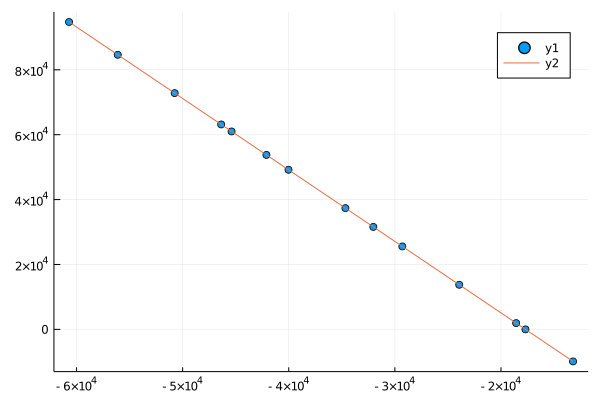

dir = norm[rayid, :] = [0.0, 0.0, -1.0]
 test :1
|| rend - rs ||/||rs|| = 0.0
 Test Passed ! 
dir = norm[rayid, :] = [-0.0, -0.0, -1.0]
ip = ijk_pos_s[IX] = 11
ray.xyzPos[ax2, :] = [-13208.028681549627, -17694.586837992847, -18571.45446570151, -23934.880249853395, -29298.306034005276, -32031.128935031167, -34661.73181815716, -40025.157602309046, -42105.26315789473, -45388.58338646093, -46367.6710320695, -50752.009170612815, -56115.43495476471, -60704.21312910782, 5.0e-324, 5.0e-324, 0.0, 0.0, 0.0, 5.0e-324, 0.0, 0.0, 0.0, 5.0e-324, 5.0e-324, 2.0e-323, 0.0, 5.0e-324, 5.0e-324, 5.0e-324, 5.0e-324, 5.0e-324, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ray.numOfElm = 14
y1 = ray.xyzPos[ax2, 1:ray.numOfElm] = [-9882.493486134943, 0.0, 1931.466910016222, 13745.427306167392, 25559.387702318556, 31578.947368421053, 37373.34809846972, 49187.30849462089, 53769.13467111366, 61001.26889077206, 63157.89473684211, 72815.22928692322, 84629.1896830744, 94736.84210526315]
x1 = ray.xyzPo

In [8]:
function testFirstTimeTraceGridOverOneLongRay(rad::RGridPar, sg::SGridPar, swch)
    rayid = rand(1:rad.Nang)
    

    @show dir = norm[rayid,:]
    posInRay = 1 #
    
    if swch=="LongRay"
        testRay = LongRay(NumElemInRayMax, rayid,          
            Array{Int64}(undef,3,NumElemInRayMax),
            Array{Float64}(undef,3,NumElemInRayMax), posInRay )       
    else
        error("swch is not supported")
    end

    
    numTests=1
    for n = 1:numTests
        println( " test :", n )
        
        ijk_pos_s[:] = [argmin(abs.(x1.-0.)), argmin(abs.(x2.-0.)), argmin(abs.(x3.-0.))]; 

        ijk_pos_s[:] = [rand( is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r) ]    
        
        ijk_pos .= ijk_pos_s

        ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]                
     
#         x3c .= [ x1[ip], x2[jp], x3[kp] ]
        
        xyz_s = [ x1[ip], x2[jp], x3[kp] ]


        FirstTimeTraceGridOverOneLongRay(dir, testRay, sg,ijk_pos)     
        
      
        
        rprev= zeros(Float64,3)
        
#         @show testRay.numOfElm
        
        if testRay.numOfElm > 0
            rprev = xyz_s
            for i=1:testRay.numOfElm
                  
                ds=LinearAlgebra.norm(testRay.xyzPos[:,i] .- rprev)

                rprev .= testRay.xyzPos[:,i]
                
#                 @show i,ds
            end
            
                   
            xyz_e = testRay.xyzPos[:,testRay.numOfElm]                
            dist = LinearAlgebra.norm( xyz_e .- xyz_s)     


            xyz_0e = xyz_s + dir*dist

            Δ = LinearAlgebra.norm( xyz_e[:].-xyz_0e[:])/
                    LinearAlgebra.norm( xyz_0e[:])


            println("|| rend - rs ||/||rs|| = ",  Δ)    
            if Δ <= 1e-5
                println(" Test Passed ! ")    
            else
                println("𝐧 = ",  dir)                
                println(" xyz_e= ",  xyz_e)                
                println(" xyz_s= ",  xyz_s)                
                println(" xyz_0e= ",  xyz_0e)                    
                println(" dist=", dist)      
                error("Test Failed !")
            end

            
        end
            

        
    end
end

function test_and_plot_ray(rad, sg)
    rayid = 2
    rayid = rand(1:rad.Nang)
    posInRay = 1 #
    x0=0. 
    y0=0. 
    z0=-2.
    
    @show dir = norm[rayid,:]
    dir = norm[rayid, :] = [-0.6300367553350504, -0.32101976096010315, 0.7071067811865476]
    
    ax1= 1
    ax2 = 2
    ax3 = 3
    
        
    ray = LongRay(NumElemInRayMax, rayid,          
            Array{Int64}(undef,3,NumElemInRayMax), Array{Float64}(undef,3,NumElemInRayMax),posInRay )       

    
    ic,jc,kc=xyzToijk(x0, y0, z0)                    
    ijk_pos .= ijk_pos_s.=[ic,jc,kc]

    
    @show  ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]                
                     
    xyz_s = [ x1[ip], x2[jp], x3[kp] ]

    FirstTimeTraceGridOverOneLongRay(dir, ray, sg, ijk_pos)     

    
    @show ray.xyzPos[ax2,:] ray.numOfElm
  
    PlotRay(ray, ax2, ax3)
    
end



testFirstTimeTraceGridOverOneLongRay(rad, sg, "LongRay")

test_and_plot_ray(rad, sg)

In [11]:
    
function GetIntersectionXYZWithBoundary(dir,ijk_pos_s)
    return(2)
end


begin
    is = is_r; ie = ie_r
    js = js_r; je = je_r 
    ks = ks_r; ke = ke_r         

    @show xbi_zip[1][1]

    for k=ks:ke        
        for j=js:je        
            for i=is:ie    

                for m=1:rad.Nang
                    dir = norm[m,:]
                    GetIntersectionXYZWithBoundary(dir,ijk_pos_s);
                end
       
        end        
    end    
end
end


# GetIntersectionWithBoundary()

(xbi_zip[1])[1] = -115789.47368421052


In [ ]:
# **************** Trace grid with long rays  ****************** #
    
println("1st time trace grid with long rays, perfom allcoations etc ..")

function TwoWayTraceGridAllocRayArr(rad::RGridPar, sg::SGridPar, swch)
    
    dirOld =Array{Float64}(undef,3)
    dirf =Array{Float64}(undef,3)
    dirb =Array{Float64}(undef,3)

    x3c_head=Array{Float64}(undef,3)
    ijk_pos_head =Array{Int64}(undef,3)
    
    Nr=NumElemInRayMax
    posInRay =1 
    
    testRay_f = LongRay(Nr,1, Array{Int64}(undef,3,Nr),Array{Float64}(undef,3,Nr),posInRay)       
    testRay_b = LongRay(Nr,1, Array{Int64}(undef,3,Nr),Array{Float64}(undef,3,Nr),posInRay)       

    
    
    if swch=="All"
        is = is_r; ie = ie_r
        js = js_r; je = je_r 
        ks = ks_r; ke = ke_r         
    elseif swch=="OneCell"
        is=ie=ijk_pos_s[IX]; js=je=ijk_pos_s[IY]; ks=ke=ijk_pos_s[IZ]
    else 
        error("Unknown case in TraceGridAllocRayArr")        
    end
         


    for k=ks:ke
#         println("k=",k, " of ",ks,":",ke)
        
        for j=js:je        

            for i=is:ie    
        


                if swch=="All"
                    ijk_pos_s.= [i,j,k]   
                end   
                
                ijk_pos_head .= ijk_pos_s #remember the origin
                
                for m=1:rad.Nang #, ipos=1:sg.Nxtot, jpos=1:sg.Nytot, kpos=1:sg.Nztot

#      @show m " new angle  ****************"
                    dirf .= norm[m,:]
                    dirb .= -norm[m,:]

                    ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]
           
                    ijk_pos .= ijk_pos_s        
                    x3c .= [ x1[ip], x2[jp], x3[kp] ]
                    
                    x3c_head .= x3c #origin 
                    
# @show "forw"
                    FirstTimeTraceGridOverOneLongRay(dirf, testRay_f, sg)        
                    
                    

                   ijk_pos .= ijk_pos_s           
                    x3c .= [ x1[ip], x2[jp], x3[kp] ]
# @show "back"
                    FirstTimeTraceGridOverOneLongRay(dirb, testRay_b, sg)                                            
        
               

#              @show  ijk_pos dirf
                    
                    # now, when the length of the ray is known, allocate arrOfLongRay[m,i,j,k]

                    Ntot = testRay_f.numOfElm + testRay_b.numOfElm +1
                    
                    origCellId = testRay_b.numOfElm + 1 #knowing origCellId one can calc the origin cell
                    
                    arrOfLongRay[m,ip,jp,kp] = LongRay(Ntot, m,            
                        Array{Int64}(undef,3,Ntot), Array{Float64}(undef,3,Ntot), origCellId)

                    arrOfLongRay[m,ip,jp,kp].id = m


                    for iter = 1:testRay_b.numOfElm
                        ib = testRay_b.numOfElm - iter+1                         
                        arrOfLongRay[m,ip,jp,kp].ijkOfCellCrossed[:,iter] = testRay_b.ijkOfCellCrossed[:,ib]                                    
                        arrOfLongRay[m,ip,jp,kp].xyzPos[:,iter] = testRay_b.xyzPos[:,ib]                                    
                   end                       

                   arrOfLongRay[m,ip,jp,kp].ijkOfCellCrossed[:,origCellId] .= ijk_pos_head
                   arrOfLongRay[m,ip,jp,kp].xyzPos[:,origCellId] .= x3c_head
                    
                    for iter = testRay_b.numOfElm + 2 : Ntot

                        i = iter - testRay_b.numOfElm -1 # 1, 2,3, ... (testRay_f.numOfElm + testRay_b.numOfElm)

                        arrOfLongRay[m,ip,jp,kp].ijkOfCellCrossed[:,iter] = testRay_f.ijkOfCellCrossed[:,i]

                        arrOfLongRay[m,ip,jp,kp].xyzPos[:,iter] = testRay_f.xyzPos[:,i]

                    end

# maxNumElemInRay =
              
                end 
            end
        end
    end
   
    
end

function testTraceGridAllocRayArr(rad, sg)            

    
    
      TwoWayTraceGridAllocRayArr(rad, sg, "All")
    
      @show is = is_r; 
      @show ie = ie_r
      js = js_r; je = je_r 
      ks = ks_r; ke = ke_r  
    
      @show ray =  arrOfLongRay[rand(1:rad.Nang),rand(is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r) ] 

end


testTraceGridAllocRayArr(rad, sg)        





# **************************************************************#    

In [ ]:
function MapAccumulateFunctionOverLongRay(ray::LongRay, st, fin, func)
    
    
    
    
end    

In [ ]:
function test3()
    rayid = rand(1:rad.Nang)

    x0=0. 
    y0=0. 
    z0=0.
      
    ax1= 1
    ax2 = 2
    ax3 = 3
    
    @show dir = norm[rayid,:]
    
    ic,jc,kc = xyzToijk(x0, y0, z0)                    


    ray =  arrOfLongRay[rayid, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]
    
    
    @show ray.xyzPos[3,:]
    
    PlotRay(ray, ax1, ax3)
    
end
test3()

<h1>
<b>
Numerical
</b>
</h1>

$$   
 \begin{equation}    
    p\frac{d^2u}{dt^2} = u - S\mbox{,}
 \end{equation}
$$  


<b> Matrix  </b> eq: 
$$
-A_i u_{i-1} + B_i u_{i} -C_i u_{i+1} = S_i
$$

Coefficients have a slightly different form compared to <b>RH91</b> for a slightly better representation of 
the numerical derivative on a staggered grid. The source term allows for implicit contribution from the $b_m u_m$ from $S$. 
 
 $$
 y_i \left(-b_m
    +\frac{p}{\delta \tau _i}
    \left(\frac{1}{\delta \tau _{i+\frac{1}{2}}}+\frac{1}{\delta \tau
   _{i-\frac{1}{2}}}\right)
   +1\right)
   -\frac{p y_{i-1}}{\delta \tau _{i-\frac{1}{2}} \delta \tau _i}
   -\frac{p y_{i+1}}{\delta \tau _i \delta \tau _{i+\frac{1}{2}}}-S_i-S_\beta=0
 $$

Boundary conditions:
    
 $$
 \text{at}\quad t = \tau_1\simeq 0: \quad \alpha \, u'(t) + \beta \, u(t) = \gamma \mbox{,} 
 $$
 
 $$
 v(\tau=0)=u(\tau=0)\mbox{,}
 $$
    
 $$
 \text{at}\quad t = \tau_N: \quad \alpha_1 \, u'(t) + \beta_1 \, u(t) = \gamma_1 \mbox{.} 
 $$


 $$
    i=1:\qquad y_1 \left(-\frac{\alpha}{\delta \tau _{\frac{3}{2}}}+\beta\right)+\frac{\alpha}{\delta \tau _{\frac{3}{2}}} y_2=\gamma
 $$
 
 $$
 i=N:\qquad
  -\frac{\alpha_1 }{\delta \tau _{N-\frac{1}{2}} }y_{N-1} +y_N \left(\frac{\alpha_1}{\delta \tau _{N-\frac{1}{2}} }+\beta_1\right)=\gamma_1
$$
 
<h>
    <b> Source function: </b>   
</h>
$$ 
S_{i}=\alpha\,\Sigma_{n}^{N_{\nu}}a_{n}\phi_{in}\,\Sigma_{m=1}^{N_{m}}b_{m}u_{imn}
$$ 
    

<h1> Coeffs and Source Function </h1>

$$   
 \begin{equation}    
    p\frac{d^2u}{dt^2} = u - S\mbox{,}
 \end{equation}
$$  

$$
p=\frac{1}{(\chi_\nu + \sigma_\nu)^2}
$$

<h1> $\Lambda$ operator within the Feautrier method </h1>

$$
\begin{equation}    
 {\bf T}\cdot {\bf u} = 
\end{equation}
$$


<!-- $$
a_1 = \Sigma(R_{lj} + C_{lj}) + C_{lu},
$$
$$
a_2 = \Sigma n_j(R_{jl} + C_{ji}),
$$

$$
a_3 = \Sigma (R_{uj} + C_{uj}) + C_{ul}
$$

$$ 
a_4 = \Sigma nj(R_{ju} + C_{ju})
$$ -->

In [ ]:

function Get_χ_ul(ν::Float64, i::Int64, j::Int64, k::Int64)
    QE = PhysConst.QE
    ME = PhysConst.ME
    CL = PhysConst.CL
#     i -lower
#     j - upper
    
    Δν_D=LineDoppWidth(LineList[NU,lineId], Tgas[i,j,k])
    
    ϕ_x = 1.0    
    ϕ_ν = ϕ_x/Δν_D
        
    χ = π *QE^2/ME/CL * LineList[F_ORSC,lineId]*
    (ndenIon[LW,i,j,k] - LineList[GSTAT_L,lineId]*ndenIon[UP,i,j,k]/LineList[GSTAT_U,lineId])*ϕ_ν

    #     @show ndenIon[UP,i,j,k],ndenIon[LW,i,j,k]LineList[GSTAT_L,lineId],LineList[GSTAT_U,lineId], QE, CL, ME, Δν_D,ϕ_ν,χ

#     χ =10.0^15
    
    if χ<0
        error("χ<0 in Get_χ_ul")        
    end
    
#     χ=0.4*6.0e14*PhysConst.MP
    
    return (χ)
    
    
end

function UpdateOpacityOnXYZGrid(sg::SGridPar)
     
    for k=1:sg.Nztot
        for j=1:sg.Nytot      
            for i=1:sg.Nxtot
                
            OpaCon[i,j,k]=2. 

            end
        end
    end  
            
end

function Get_ϵ_th(lineId::Int64,i::Int64, j::Int64, k::Int64)

    Te::Float64 =  Tgas[i,j,k]
    
    C_ul :: Float64 = 0.1
    A_ul :: Float64 = 0.1
    
    ν ::Float64 = LineList[NU,lineId]
    
    y::Float64 = PhysConst.HPL*ν/PhysConst.KBLZ/Te
    
    expon::Float64 = exp(-y)
    
    ϵ1::Float64 = C_ul*(1.0 - expon)/A_ul    
    
    ϵ::Float64 = ϵ1/(1.0+ϵ1)    
    
    return(ϵ)
end

function SrcFun(ν::Float64, i::Int64,j::Int64,k::Int64)

#     T =  Tgas[i,j,k]
    
    Sf::Float64  = 0.0;
    
    j_ν::Float64 = EmissivityCoeffficient(ν,i,j,k)
    κ_ν::Float64 = OpacityRecombination(ν,i,j,k)
    
#      Sf = Bν(ν, T)

    Sf = j_ν/κ_ν
    
    return(Sf)
        
end

    
function SrcFun2lev(ν::Float64, i::Int64, j::Int64, k::Int64) # 2 level atom 

    # ϵ::Float64, lineId::Int64, u::Float64, 
    
    Te::Float64 =  Tgas[i,j,k]
            
    Sf::Float64 = 0.0 #2.0PhysConst.HPL*ν^3/PhysConst.CL^2/((n_l*g_u/n_u/g_l)-1.0) 
            
    Bp::Float64 = Bν(ν,Te) 
    
    ϵ_th =  Get_ϵ_th(lineId, i,j,k)
#     @show ϵ_th

    ϵ_th = 1.0
    
    Jbar = Jν[lineId, i,j,k]

    Sf = (1.0-ϵ_th)*Jbar + ϵ_th*Bp
                            
    return(Sf)
        
end


# GetSourceFuncParams(1, 1,1,1,)

Get_χ_ul(LineList[NU,lineId], sg.is, sg.js, sg.ks)

SrcFun2lev(LineList[NU,lineId],rand( is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r))



In [ ]:
# ijk_start_end = zeros(Float64,3,2)

# @show ijk_start_end = [[is_r, ie_r] [js_r,je_r] [ks_r,ke_r]]

@show ijk_start_end = [[sg.is, sg.ie] [sg.js,sg.je] [sg.ks,sg.ke]]
# 

bndNorm = zeros(Float64,6,3)

bndNorm[1,:] .= [-1,0,0]
bndNorm[2,:] .= [1,0,0]
bndNorm[3,:] .= [0,-1,0]
bndNorm[4,:] .= [0,1,0]
bndNorm[5,:] .= [0,0,-1]
bndNorm[6,:] .= [0,0,1]


ijk_bc = zeros(Float64,3)        



function GiveIrradiationIntensity()
 Iirrad = 0.0
end

function Give_BC_β(bndryIndexOnRay,χ, ray::LongRay, i::Int64, j::Int64, k::Int64)    
    
#     i0 = ray.numOfElm
    
#     @show ijk_ray_bc = [ray.ijkOfCellCrossed[1,i0],ray.ijkOfCellCrossed[2,i0],ray.ijkOfCellCrossed[3,i0]] 
#     @show i j k   
    
    rayDir = norm[ray.id,:]
    
    gam ::Float64=0.0
    bet ::Float64=0.0

        
    if ray.xyzPos[3,bndryIndexOnRay] <= x3[ks_r]                
              
                r = rayDir[3]*bndNorm[5,3]

                if r<0 #back of the ray
                    
                  Iplus = GiveIrradiationIntensity()
                  
                  bet = -χ
                  
                  gam = -χ*Iplus
                    
                elseif r>0 #face of the ray
            
                  #irradiation can be I^+ or. I^-
            
                  Iminus = GiveIrradiationIntensity()
            
                  bet = χ
            
                  gam=χ*Iminus
                        
                else
                  error("case not knowm in Give_BC_β:
                    ", rayDir, "\n", bndNorm[5,:])
                end
    end
        

    return(gam,bet)
    
end                    



function ProgRayBC_1(ν::Float64, χ::Float64, ray::LongRay,i::Int64, j::Int64, k::Int64)
    is = is_r; ie = ie_r    
    js = js_r; je = je_r 
    ks = ks_r; ke = ke_r         

# y, ray, ic,jc,kc
# , norm[ray.id,:]
    
    gam,bet = Give_BC_β(1, χ, ray,i,j,k) 
    
    alph = 1.0      
    
#     gam = 0.0 #Bν(ν, T)
        
    return(alph, bet, gam)
    
end


function ProgRayBC_N(ν::Float64, χ::Float64, ray::LongRay, i::Int64,j::Int64,k::Int64)
    
    gamN,betN = Give_BC_β(ray.numOfElm,χ,ray,i,j,k)
    
    alphN = 1.        

#     gamN = 0.
    
    return(alphN,betN,gamN)
    
end

function ProgRay_pCoef(ν::Float64, χ::Float64, i::Int64,j::Int64,k::Int64)
    
    p::Float64 = 1/χ^2

    return(p)
end    

# let
# @show χ1 = Get_χ_ul(LineList[NU,lineId],sg.is, sg.js, sg.ks)
# @show ProgRayBC_1(LineList[NU,lineId], χ1, sg.is, sg.js, sg.ks,
# arrOfLongRay[m,3,3,3].dir)    
# @show ProgRayBC_N(LineList[NU,lineId], χ1, sg.is, sg.js, sg.ks)
# @show ProgRay_pCoef(LineList[NU,lineId],χ1, sg.is, sg.js, sg.ks)
# end






λii  = zeros(Float64,maxNumElemInRay)

λii_mu = zeros(Float64,rad.Nang)

χ_OnRay = zeros(Float64,maxNumElemInRay) #precalculated χ_line, on a ray

Ipos = zeros(Float64,maxNumElemInRay) 
Ineg = zeros(Float64,maxNumElemInRay) 


Sf_ray = zeros(Float64,maxNumElemInRay)



function ProgonRybHumAlongTheRay(ν::Float64, ray::LongRay, sg::SGridPar, rad::RGridPar)

    Nmat = ray.numOfElm
    
    u = zeros(Float64, Nmat)
    v = zeros(Float64, Nmat)
    
    
    A = zeros(Float64, Nmat)
    B = zeros(Float64, Nmat)    
    C = zeros(Float64, Nmat)
    D = zeros(Float64, Nmat)
    Z = zeros(Float64, Nmat)
    S = zeros(Float64, Nmat) #Rhs


    Sbet =0.
    bm = 0
    

    ic,jc,kc = ray.ijkOfCellCrossed[1,1],ray.ijkOfCellCrossed[2,1],ray.ijkOfCellCrossed[3,1]
    
    @show x3[kc]
    
    χ_OnRay[1] = Get_χ_ul(ν,ic,jc,kc)

    alph,bet,gam = ProgRayBC_1(ν,χ_OnRay[1], ray, ic,jc,kc)
    
                       
    dx_i1 = LinearAlgebra.norm(ray.xyzPos[:,2].-ray.xyzPos[:,1])     
    dx_i=dx_i1 
    dx_ip05 = dx_i
    
    
    
    p = ProgRay_pCoef(ν,χ_OnRay[1], ic,jc,kc)
            
    A[1] = 0.    
    B[1] = (bet - alph/dx_ip05)
    C[1] = (-alph/dx_ip05)    
    S[1] = (gam)    
    
    
    
    D[1] = C[1]/B[1]
    Z[1] = S[1]/B[1]
    
    C[Nmat]=0.
     
    if isnan(D[1]) || B[1] ==0
        error("atten")
    end
        
#     @show Z[1] S[1]
    
    for i = 2 : Nmat-1 #forward            
        ic,jc,kc = ray.ijkOfCellCrossed[1,i],ray.ijkOfCellCrossed[2,i],ray.ijkOfCellCrossed[3,i]
                        
        χ_OnRay[i] = Get_χ_ul(ν,ic,jc,kc)
        
        dx_i = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i])

#         @show χ_OnRay[i],"dτ=",dx_i*χ_OnRay[i]
        
        if dx_i==0
            @show "warn: " Nmat, i, ic,jc,kc, ray.xyzPos[:,i+1],ray.xyzPos[:,i]
            error("dx=0 in ProgonRybHumAlongTheRay")
        end
            
        dx_im05 = dx_i         
        dx_ip05 = dx_i  

        p = ProgRay_pCoef(ν,χ_OnRay[i], ic,jc,kc)
        
        Sd = SrcFun2lev(ν, ic,jc,kc)
        
       S[i] = Sd + Sbet
        
       A[i] = p /(dx_i*dx_im05)         
       B[i] = 1. - bm + ((1/dx_im05 + 1/dx_ip05)*p)/dx_i        
       C[i] = p/(dx_i*dx_ip05)  
                        
       k1 = 1/(B[i] - A[i]D[i-1])   

       D[i] = k1*C[i]        
       Z[i] = k1*( S[i]  + A[i]*Z[i-1] )                     
                
#         @show i Sd S[i] A[i] B[i] C[i] D[i] Z[i] Z[i-1] k1 ν
    end 

    ic,jc,kc = ray.ijkOfCellCrossed[1,Nmat],ray.ijkOfCellCrossed[2,Nmat],ray.ijkOfCellCrossed[3,Nmat]    
        
    χ_OnRay[Nmat] = Get_χ_ul(ν,ic,jc,kc)
    
    alphN,betN,gamN = ProgRayBC_N(ν, χ_OnRay[Nmat], ray, ic,jc,kc)

    dx_im05 = dx_i         
    dx_ip05 = dx_i 
    S[Nmat] = gamN
    
    C[Nmat]=0.
    D[Nmat]=0.

    A[Nmat] = (alphN/dx_im05)
    B[Nmat] = betN + alphN/dx_im05
    
    k1 = 1/(B[Nmat] - A[Nmat]*D[Nmat-1])
    
    Z[Nmat] = k1*(S[Nmat]  + A[Nmat]*Z[Nmat-1])                     

    u[Nmat] = Z[Nmat]
    v[Nmat] = u[Nmat]
    
    
    E_ip1 = 0.0
    for i = Nmat-1:-1:1  #backsweep

        u[i] = D[i]*u[i+1]+Z[i]
        
        dx_i = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i])        
        @show duds = (u[i+1]-u[i])/dx_i   
                
        ic,jc,kc = ray.ijkOfCellCrossed[1,i],ray.ijkOfCellCrossed[2,i],ray.ijkOfCellCrossed[3,i]
        
         @show  u[i] ic jc kc #ray.xyzPos[:,i] x3[sg.ks]
                
        chi = χ_OnRay[i]
        v[i] = -1.0/chi*duds
                        
        E_i = A[i]/(B[i]-C[i]*E_ip1)    #needed for Λ-operator        
        
        D_im1 = i>1 ? D[i-1] : 0.0        
        
        λii[i] = 1.0/((1.0-D[i]*E_ip1)*(B[i]-A[i]*D_im1))
        
        E_ip1 = E_i
        
    end #for  
    
    #  calculate v at the origin     

#     i1 = ray.orig    
#     ic,jc,kc = ray.ijkOfCellCrossed[1,i1],ray.ijkOfCellCrossed[2,i1],ray.ijkOfCellCrossed[3,i1]
#     dx_i = LinearAlgebra.norm(ray.xyzPos[:,i1+1].-ray.xyzPos[:,i1])    
#     duds = (u[i1+1]-u[i1])/dx_i        
#     chi = OpaCon[ic,jc,kc]        
#     println("ProgonRybHumAlongTheRay done .. ")
#     @show λii
    
    return(u,v,λii)
    
end #RTAlongTheRay




# tests
function TestRybHumAlongTheRay(rad)
    # pick a ray

    
    ijk_pos_s[:]= [rand(sg.is:sg.ie),  rand(sg.js:sg.je),  rand(sg.ks:sg.ke) ]    
    ijk_pos_s[:]= [rand( is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r) ]    
    
#     ijk_pos = [0.0,0.0,0.0]
#     ijk_pos_s[:] = [sg.is,  sg.je,  rand(sg.ks:sg.ke) ]        
#     ijk_pos_s[:] = [is_r,  je_r,  rand(ks_r:ke_r) ]    
    
    ijk_pos_s[1],ijk_pos_s[2], ijk_pos_s[3] =  xyzToijk( -0.5, 0.0, 0.0 )
    
    
    NumTests=1
    
    Δ=0.
    

    for k=1:NumTests
        
        ijk_pos .= ijk_pos_s
        
        m = rand(1:rad.Nang)        
        m=rad.NumTheta
        m=1
        
        @show dir = norm[m,:]
        
        #need to first run=: TraceGridAllocRayArr(rad, sg)            
        
        ray =  arrOfLongRay[m, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]         
        λii = zeros(Float64, ray.numOfElm) #diagonal elements of the Λ operator
        
#         @show ray.numOfElm ray.ijkOfCellCrossed            
#         if ray.numOfElm > 1        

        s = zeros(Float64,ray.numOfElm) #dist along the ray
        
        s[1]=0.


        
#     end
        
#         @show s νi = νRange[1]
        νi = νRange[1]
        u1,v1 = ProgonRybHumAlongTheRay(νi, ray, sg, rad)    
        
#         @show u1 v1
#         u,v = ProgonRybHumAlongTheRayAppndxA(νi, ray, sg, rad);    

        Ipos[1]=Ineg[1]=0.0

        for i = 2:ray.numOfElm
               s[i] =  s[i-1] + LinearAlgebra.norm(ray.xyzPos[:,i]-ray.xyzPos[:,i-1])     
            
               Ipos[i] = u1[i] + v1[i]            
               Ineg[i] = u1[i] - v1[i]           
            
            ic,jc,kc = ray.ijkOfCellCrossed[1,ray.numOfElm],ray.ijkOfCellCrossed[2,ray.numOfElm],ray.ijkOfCellCrossed[3,ray.numOfElm]  
            
            Sf_ray[i] = SrcFun2lev(νi, ic,jc,kc)
            
        end

        
        plt = plot(layout = (3, 2))

        plot!(plt[1],s, Ipos[1:ray.numOfElm],label = "I^{+}")
        plot!(plt[2],s, Ineg[1:ray.numOfElm],label = "I^{-}")        
        plot!(plt[3],s, u1,label = "u")
        plot!(plt[4],s, v1,label = "v")        
        plot!(plt[5],s, Sf_ray[1:ray.numOfElm],label = "Sf")
        
        display(plt)

#       @show length(u1) length(u) length(v) length(v1)

        
#         Δ += LinearAlgebra.norm((u-u1)./u1) + LinearAlgebra.norm((v-v1[1])./v1)
        
#     println( "relative difference between ProgonRybHumAlongTheRayAppndxA 
#         and ProgonRybHumAlongTheRay:\n Δu/u=", Δ )    

#     if Δ <= 1e-2
#         println(" Test Passed ! ")    
#     else
#         @show ijk_pos_s
#         @show u 
#         @show u1
#         @show v1
#         @show ray.ijkOfCellCrossed 
#         @show ray.xyzPos
            
        
            
#   error( " Test Failed !")
#     end
        
    end



end



lineId = 1

InitializeMatter(sg,rad)

InitializeRadiationFunctions(ν_min,ν_max,"BB", rad)

UpdateOpacityOnXYZGrid(sg)

TestRybHumAlongTheRay(rad)



In [ ]:

function testALI(sg::SGridPar, rad::RGridPar)
 
    is = is_r; ie = ie_r    
    js = js_r; je = je_r 
    ks = ks_r; ke = ke_r         

#     UpdateOpacGrid(sg)
    
    InitializeRadiationFunctions(ν_min, ν_max,"BB", rad)
    
    ϵ_th = Get_ϵ_th(lineId, is,js,ks)


    max_iter=5;    
    iter_λ = 1;
    track = [0,0]

#     @show i,j,k = [rand( is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r)]    
#     @show i,j,k =  xyzToijk( 0.0, 0.0, 0.0 )
    
    i,j,k = sg.is+3,10,10
    
    while iter_λ <= max_iter          
            
                       
#     for k=ks:ke
#         for j=js:je        
#             for i=is:ie  

                                                                
    for l = 1:1 #rad.Nfreq 
    

                    f = lineId
                    Jnew =0.0  #mean intens, J 
                    Λ = 0.0  # Λ-operator
        
                    for m=1:rad.Nang

#                         @show norm[m,:]
                                                            
                        νi = LineList[NU,lineId]                        
                        ray =  arrOfLongRay[m,i,j,k]
                        λii = zeros(Float64, ray.numOfElm) #diagonal elements of the Λ operator
                
                        u, v, λii = ProgonRybHumAlongTheRay(νi, ray, sg, rad);  
                
                        i_1 = ray.orig
                        u_1 = u[i_1]

#                         λii_mu[m] = λii[i_1]   
# @show  λii[i_1]             
                        Λ += ( 1.0 - (1.0 - ϵ_th)*λii[i_1] )
            
                        IrPos[m,i,j,k] = u[i_1] + v[i_1]
                        IrNeg[m,i,j,k] = u[i_1] - v[i_1]   

                        Jnew += u_1 #(IrPos[m,i,j,k] + IrNeg[m,i,j,k])                                                                                                            
                        
                    end # m - angle

        
                    Λ /= rad.Nang                
                    Λ_1 = 1.0/Λ        
                    Jnew  = Jnew/rad.Nang

            
# println(Jν[f,i,j,k], " ", Jnew)                  
            
                    Jν[f,i,j,k] = Jnew  
            
                    S_FS = SrcFun2lev(LineList[NU,lineId], i, j, k) #intermed. Sf
                    S_old = Sν[f,i,j,k]            

# println(lambda_iter, ": ", S_old, " ", S_FS)            
            
                    ΔS = ΔS_FS = S_FS - S_old
                    ΔS = Λ_1 * ΔS_FS                        
                        
                        
#                     @show ΔS,ΔS_FS                                
            
                        
                    Sν[f,i,j,k] =  Sν[f,i,j,k] + ΔS
                    
                                            
                        if  abs(ΔS/S_old)<1.E-3
                            track[1] += 1
                            println("converged: ",(i,j,k),", iter_λ=", iter_λ,", ΔS/S_old = ", ΔS/S_old)
                            break
                        elseif iter_λ>=max_iter
 
                            track[2] += 1
#                             println("did not converge ",(i,j,k),", iter_λ=", iter_λ,", ΔS/S_old = ", ΔS/S_old)
                        end

                        
                        

              
                    end #f - freq                                        
    
    
#             end # -i
#         end # -j
#     end # -k

        iter_λ += 1
        end    #lambda_iter   

    println("converged:  ", track[1], "  did not converge:  ", track[2])

end


    
    testALI(sg,rad)



In [ ]:

rayP =  arrOfLongRay[1,4,4,4]

arrOfLongRay[1,4,4,4].ijkOfCellCrossed[:,end]

# arrOfLongRay

In [ ]:

function RT_testAllGridALI(sg::SGridPar, rad::RGridPar)
       
    is = is_r; ie = ie_r    
    js = js_r; je = je_r 
    ks = ks_r; ke = ke_r         

    UpdateOpacityOnXYZGrid(sg)
    
    
     ϵ_th = Get_ϵ_th(lineId, is,js,ks)


#     tst
    max_num_ang = 1; #rad.Nang
    is=ie=js=je=k1=ke
    
    
    max_iter=5; 
    iter_λ = 1;

    while iter_λ <= max_iter          
    
    
        
    for k=ks:ke
        for j=js:je        
            for i=is:ie  
    
    for l = 1:max_num_ang
          
                    f = lineId
                    Jnew =0.0  #mean intens, J 
                    Λ = 0.0  # Λ-operator
        
                    for m=1:rad.Nang

@show norm[m,:]
                                                            
                        νi = LineList[NU,lineId]                        
                        ray =  arrOfLongRay[m,i,j,k]
                        λii = zeros(Float64, ray.numOfElm) #diagonal elements of the Λ operator
                
                        u, v, λii = ProgonRybHumAlongTheRay(νi, ray, sg, rad);  
                
                        i_1 = ray.orig
                        u_1 = u[i_1]

#                         λii_mu[m] = λii[i_1]   
# @show  λii[i_1]             
                        Λ += ( 1.0 - (1.0 - ϵ_th)*λii[i_1] )
            
                        IrPos[m,i,j,k] = u[i_1] + v[i_1]
                        IrNeg[m,i,j,k] = u[i_1] - v[i_1]   

                        Jnew += u_1 #(IrPos[m,i,j,k] + IrNeg[m,i,j,k])                                                                                                            
                        
                    end # m - angle

        
                        Λ /= rad.Nang                
                        Λ_1 = 1.0/Λ
        
                        Jnew  = Jnew/rad.Nang

            
# println(Jν[f,i,j,k], " ", Jnew)                  
            
                    Jν[f,i,j,k] = Jnew
                    
                    S_FS = SrcFun2lev(LineList[NU,lineId], i, j, k) #intermed. Sf
                    S_old = Sν[f,i,j,k]            

# println(lambda_iter, ": ", S_old, " ", S_FS)            
            
                    ΔS = ΔS_FS = S_FS - S_old

                    ΔS = Λ_1 * ΔS_FS                        
                        
                        
#                     @show ΔS,ΔS_FS                                
            
                        
                    Sν[f,i,j,k] =  Sν[f,i,j,k] + ΔS
                    
                    
                        

                        if  abs(ΔS/S_old)<1.E-3
                            println((i,j,k),", iter_λ=", iter_λ,", ΔS/S_old = ", ΔS/S_old)
                            break
                        elseif iter_λ>=max_iter
                            println("did not converge ",(i,j,k),", iter_λ=", iter_λ,", ΔS/S_old = ", ΔS/S_old)
                        end

                        
                        

              
                    end #f - freq                                        
    
    
            end # -i
        end # -j
    end # -k

        iter_λ += 1
        end    #lambda_iter   

    println("RT_testAllGridALI done ..")
end


    # 1
    RT_testAllGridALI(sg,rad)



In [ ]:
using Plots
import GR

function PlotRad(x::Float64, y::Float64, z::Float64)
    @show ic,jc,kc = xyzToijk(x,y,z)
    
    y = IrPos[:,ic,jc,kc]
    
    @show size(y), size(μ) rad.Nang
    
    plot(1:rad.Nang, y)
    
end


PlotRad(0.,0.,0.)

In [ ]:
#  using PyPlot 
# using Plots
# gr() 


using Plots
import GR
gr()

function RTSolveTwoWayRay(RayIndex::Int64)        
   
   
    
    # pick a ray
    rayf =  rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].ray_f
    uf  = ProgonRybHumAlongTheRayAppndxA(rayf, sg, rad); #forward
    
    
#     @show RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]
    # @show rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].dir

  
    #     change direction                
     rayb =  rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].ray_b
     ub  = ProgonRybHumAlongTheRayAppndxA(rayb, sg, rad); #backward    
      
      utot = zeros(Float64,length(ub)+length(uf))    
    
#     utot[1:length(ub)] .= ub
#     plot(utot);    
    
    
    @show ub[1] uf[1]

    u = 0.5(uf[1] + ub[1])
    
        

    
end 


    
ijk_pos_s[:] = [rand(sg.is:sg.ie),  rand(sg.js:sg.je),  rand(sg.ks:sg.ke) ]
    
ijk_pos_s[:] = [argmin(abs.(x1.-0.)), argmin(abs.(x2.-0.)), argmin(abs.(x3.-0.))];   



TraceGridBothWaysAllocateArr(rad, sg)

for m=1:rad.N_fre_ang 
    den .= 1.
    opa .= 1.
    RTSolveTwoWayRay(m)
end


In [ ]:
# logger=Logging.SimpleLogger(stderr,Logging.Debug)

function TestOneRay(ray, sg)
    xyz_s=Vector{Float64}(undef,3)    
    xyz_e=Vector{Float64}(undef,3)    
    xyz_0e=Vector{Float64}(undef,3)
    
    xyz_s .= ray.xyzPos[:,1]
    
    xyz_e = ray.xyzPos[:,ray.numOfElm]

    dist =LinearAlgebra.norm( xyz_e[:].-xyz_s[:]) 
    
    xyz_0e = xyz_s + ray.dir*dist
    
    
    @show xyz_e, xyz_0e, dist
    
    println("|| rend - rs || = ",  LinearAlgebra.norm( xyz_e[:].-xyz_0e[:]) )
    
end


TestOneRay(rayOne, sg)



In [ ]:
module debugByPlot

using Plots
# x= LinRange(0,30,10)

# import 

x = [0.5, 1.]
y = [0., 1.]
z = [0., 0.1];


plt=plot3d(x,y,z)



end


In [ ]:
ray = arrOfLongRay[rand(1:rad.Nang), ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]


function PlotRay(ray, sg)
    
    x = ray.xyzPos[1,1:ray.numOfElm]
    y = ray.xyzPos[2,1:ray.numOfElm]   
    z = ray.xyzPos[3,1:ray.numOfElm]      
    
    @show ray.numOfElm,x,y,z

    plot3d(x,y,z,
        xlabel = "x", ylabel = "y", zlabel = "z", 
        xlim= (sg.x1s,sg.x1e),ylim= (sg.x2s,sg.x2e),zlim= (sg.x3s,sg.x3e))    
end



# plt=PlotRay(rayOne, sg); display(plt)    
# display(plt)    
# inline()
# end #module RadiationTransfer




  


In [ ]:
<b> Ionization balance  </b>

\begin{equation}  
\frac{4\pi}{n_H}\int_{\nu_1}^{\nu_2}\chi_\nu J_\nu\,d\nu
=\frac{n_e n^+}{n_H}\Sigma_{n=1}^\infty\alpha_\nu(T_e)\simeq \frac{n_e n^+}{n_H}{\hat \alpha}_1
\end{equation}     
 
<b> + Radiation transfer  </b> 

\begin{equation}  
{\bf \rm RT}\left(\chi_\nu, j_\nu\right) =0
\end{equation} 
    



In [ ]:
function ProgonRybHumAlongTheRayAppndxA(ν,  ray::LongRay, sg::SGridPar, rad::RGridPar)
    
    Nmat = ray.numOfElm

    u = zeros(Float64, Nmat)
        
    D = zeros(Float64, Nmat)
    H = zeros(Float64, Nmat)
    F = zeros(Float64, Nmat)
    Z = zeros(Float64, Nmat)    

    
    Sbet =0.
    bm = 0.
    
    ic,jc,kc = ray.ijkOfCellCrossed[1,1],ray.ijkOfCellCrossed[2,1],ray.ijkOfCellCrossed[3,1]
    
    alph,bet,gam = ProgRayBC_1(ν, ic,jc,kc)
    
    dx_i1 = LinearAlgebra.norm(ray.xyzPos[:,2].-ray.xyzPos[:,1])     
    dx_i=dx_i1 
    dx_ip05 = dx_i
        
    p = ProgRay_pCoef(ν, ic,jc,kc)

    
    B1 = -bet + alph/dx_ip05
    C1 = alph/dx_ip05
    S1 = gam

    H[1] = B1 - C1    
    F[1] = H[1]/C1
    Z[1] = S1/B1    
    
    
    for i = 2 : Nmat-1 #forward                        
        ic,jc,kc = ray.ijkOfCellCrossed[1,i],ray.ijkOfCellCrossed[2,i],ray.ijkOfCellCrossed[3,i]
                
        dx_i = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i])     
     
        if dx_i==0
            @show "warn: " Nmat, i, ic,jc,kc, ray.xyzPos[:,i+1],ray.xyzPos[:,i]    
            error("dx=0 in ProgonRybHumAlongTheRay")        
        end
       
        dx_im05 = dx_i         
        dx_ip05 = dx_i  

        p=ProgRay_pCoef(ν, ic,jc,kc)
        
        Sd = SrcFun2lev(ν, ic,jc,kc)        
        Si = Sd+Sbet
        
        Ai = p/(dx_i*dx_im05)         
        Bi = 1.0 - bm + ((1/dx_im05 + 1/dx_ip05)*p)/dx_i        
        Ci = p/(dx_i*dx_ip05)  
        H[i] = -Ai + Bi - Ci                
        F[i]=(H[i]+(Ai*F[i-1])/(1+F[i-1]))/Ci        
        Z[i]=(Si+Ai*Z[i-1])/(1+F[i])/Ci      
        
    end 

    ic,jc,kc = ray.ijkOfCellCrossed[1,Nmat],ray.ijkOfCellCrossed[2,Nmat],ray.ijkOfCellCrossed[3,Nmat]    
    alphN,betN,gamN = ProgRayBC_N(ν, ic,jc,kc)

    dx_im05 = dx_i         
    dx_ip05 = dx_i 
    SN = gamN    
    CN = 0.

    AN = (alphN/dx_im05)
    BN = betN + alphN/dx_im05    
    Dnm1 = 1/(1.0+F[Nmat-1])        
    Z[Nmat] = (SN+AN*Z[Nmat-1])/(BN - AN*Dnm1)                         
    u[Nmat] = Z[Nmat]

    for i = Nmat-1:-1:1  #backsweep   
        u[i] = u[i+1]/(1+F[i]) + Z[i]
    end 
    
#     println("... ProgonRybHumAlongTheRayAppndxA done")
   
    i1=1
    ic,jc,kc = ray.ijkOfCellCrossed[1,i1],ray.ijkOfCellCrossed[2,i1],ray.ijkOfCellCrossed[3,i1]

    dx_i = LinearAlgebra.norm(ray.xyzPos[:,i1+1].-ray.xyzPos[:,i1])
    
    @show duds = (u[2]-u[1])/dx_i    
    
    chi = OpaCon[ic,jc,kc]    
    
    v = -1/chi*duds  
    
    println("ProgonRybHumAlongTheRayAppndxA done .. ")
    
    return(u,v)
    
end #RTAlongTheRay